In [7]:
using Pkg
Pkg.add("Ipopt")
Pkg.add("JuMP")

   Resolving package versions...
  No Changes to `C:\Users\batagoda\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\batagoda\.julia\environments\v1.10\Manifest.toml`
Precompiling project...
    Unitful Being precompiled by another process (pid: 28580, pidfile: C:\Users\batagoda\.julia\compiled\v1.10\Unitful\5WYj5_tm3GZ.ji.pidfile)
    ColorSchemes Being precompiled by another process (pid: 28580, pidfile: C:\Users\batagoda\.julia\compiled\v1.10\ColorSchemes\EO5fj_tm3GZ.ji.pidfile)
  ✓ FFMPEG
  ✓ Qt6Base_jll
  ✓ GR_jll
    GR Being precompiled by another process (pid: 28580, pidfile: C:\Users\batagoda\.julia\compiled\v1.10\GR\NDU5Y_tm3GZ.ji.pidfile)
  ✓ Unitful
  ✓ ColorSchemes
    UnitfulLatexify Being precompiled by another process (pid: 28580, pidfile: C:\Users\batagoda\.julia\compiled\v1.10\UnitfulLatexify\trCzg_tm3GZ.ji.pidfile)
    PlotUtils Being precompiled by another process (pid: 28580, pidfile: C:\Users\batagoda\.julia\compiled\v1.10\PlotUtils\YveHG_tm3GZ.ji

In [1]:
using CSV
using JuMP
using Ipopt
using DataFrames
using Plots
using LinearAlgebra
using Gurobi

In [48]:
trajectory_data = DataFrame(CSV.File("traj2d.csv"));
ref_trajectory= Matrix(trajectory_data)

1000×13 Matrix{Float64}:
  0.01  3.0      5.0      -0.14316   …   -1.60589  -11.3203     2.6112
  0.02  3.00001  5.0      -0.142875      -1.57978  -11.3203     2.6112
  0.03  3.00005  4.99999  -0.142588      -1.55367  -11.3203     2.6112
  0.04  3.00012  4.99998  -0.142299      -1.52755  -11.3203     2.6112
  0.05  3.00023  4.99997  -0.142009      -1.50144  -11.3203     2.6112
  0.06  3.0004   4.99994  -0.141716  …   -1.47533  -11.3203     2.6112
  0.07  3.00063  4.99991  -0.141421      -1.44922  -11.3203     2.6112
  0.08  3.00094  4.99987  -0.141124      -1.42311  -11.3203     2.6112
  0.09  3.00134  4.99981  -0.140825      -1.39699  -11.3203     2.6112
  0.1   3.00184  4.99974  -0.140524      -1.37088  -11.3203     2.6112
  0.11  3.00244  4.99965  -0.14022   …   -1.34477  -11.3203     2.6112
  0.12  3.00316  4.99955  -0.139915      -1.31866  -11.3203     2.6112
  0.13  3.004    4.99943  -0.139608      -1.29255  -11.3203     2.6112
  ⋮                                  ⋱    ⋮         

In [49]:
N = size(ref_trajectory)[1]
ref_trajectory[1,5:6][2]
N

1000

In [53]:
function A_k(x, dxdy)
    A = [0 0  -dxdy[2];
         0 0  dxdy[1];
         0 0  0];
    return A
end

function B_k(x, dxdy)
    phi = atan( 2*(dxdy[1]*dxdy[5] - dxdy[4]*dxdy[2]) / (dxdy[1]^2 + dxdy[2]^2)^(3/2) );
    theta = atan( dxdy[2] / dxdy[1] );
    if isnan(phi)
        phi = 0
    end
    if isnan(theta)
        theta = 0
    end
    v = dxdy[1] / cos(theta);
    B = [cos(theta) 0;
         sin(theta) 0;
         1/tan(phi) (v/2)*sec(phi)^2];
    return B, phi, v
end


# For each entry in the reference trajectory, comput a A and B matrix
A = zeros(3,3,N)
B = zeros(3,2,N)
phi = zeros(N)
v = zeros(N)
for i in 1:N
    #println(N)
    x = ref_trajectory[i,5:6]
    dxdy = ref_trajectory[i,5:9]
    A[:,:,i] = A_k(x, dxdy)
    B[:,:,i], phi[i], v[i] = B_k(x, dxdy)

end


In [56]:
[v[1];phi[1]]

2-element Vector{Float64}:
 0.000568893052821811
 1.5607810289714124

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3000

Total number of variables............................:     3000
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2153423e+05 5.00e+00 3.53e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

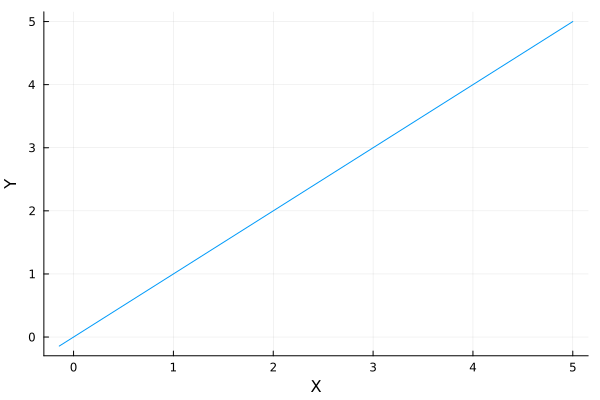

In [66]:



# Parameters
#N = 100 # Number of time steps
L = 2 # Wheelbase, example value
# r_safe = 0.0 # Safety radius
# obstacles = [(1, 2, 1)] # Each tuple: (o_x, o_y, r)

# Initial conditions
x0 = ref_trajectory[1, 2:4] # Initial state [x, y, theta]
#initial_guess = repmat(x0, N)

# Bounds
xmin = fill(-Inf, 3)
xmax = fill(Inf, 3)
umin = [-5, -π/4] # velocity and steering angle limits
umax = [5, π/4]

# Weight matrices
Q = I(3)
R = I(2)
P = I(3)

# Create JuMP model
model = Model(Ipopt.Optimizer)

# Define decision variables
@variable(model, x[1:N, 1:3])
#@variable(model, u[1:N, 1:2])

# Objective function
# @objective(model, Min,
# sum( (x[k, 1:2] - ref_trajectory[k, 2:3]).^2 for k = 1:N) +
# (x[N, 1:2] - ref_trajectory[N, 1:2]).^2 +
# sum( u[k, :].^2 for k = 1:N-1)
# )

@objective(model, Min,
sum( (x[k, 1] - ref_trajectory[k, 2])^2 for k = 1:N) +
sum( (x[k, 2] - ref_trajectory[k, 3])^2 for k = 1:N) +
sum( (x[k, 3] - ref_trajectory[k, 4])^2 for k = 1:N) +
(x[N, 1] - ref_trajectory[N, 2])^2 +
(x[N, 2] - ref_trajectory[N, 3])^2 +
(x[N, 3] - ref_trajectory[N, 4])^2
# sum( u[k, 1]^2 for k = 1:N-1) +
# sum( u[k, 2]^2 for k = 1:N-1)
)


# System dynamics constraints
# for k = 1:N-1
#     @constraint(model, x[k+1, :] .== A[:,:,k] * (x[k, :] - ref_trajectory[k,2:4]) + B[:,:,k]* (u[k, :] - [v[k];phi[k]]))
# end

#State and control bounds
# for k = 1:N
#     @constraint(model, ref_trajectory[k,2] - 1 .<= x[k, 1] .<= ref_trajectory[k,2] + 1)
#     @constraint(model, ref_trajectory[k,3] - 1 .<= x[k, 2] .<= ref_trajectory[k,3] + 1)
# end

# for k = 1:N
#     @constraint(model, umin .<= u[k, :] .<= umax)
# end

# Obstacle avoidance constraints
# for j = 1:length(obstacles)
#    for k = 1:N
#        @constraint(model, (x[k,1] - obstacles[j][1])^2 + (x[k, 2] - obstacles[j][2])^2 >= (obstacles[j][3] + r_safe)^2)
#    end
# end

# Set initial condition
@constraint(model, x[1,:] .== x0)

# set final condition
@constraint(model, x[N, :] .== ref_trajectory[N, 2:4])

# Solve the optimization problem
optimize!(model)

# Retrieve optimized trajectory
x_opt = value.(x)




x_data = x_opt[1, :]
y_data = x_opt[2, :]
# plot original trajectory
plot(ref_trajectory[1:N, 2], ref_trajectory[1:N, 3], label="Reference Trajectory", xlabel="X", ylabel="Y", legend=true)
plot(x_data, y_data, xlabel="X", ylabel="Y", legend=false)

In [62]:
println(model)

Min x[1,1]² + x[2,1]² + x[3,1]² + x[4,1]² + x[5,1]² + x[6,1]² + x[7,1]² + x[8,1]² + x[9,1]² + x[10,1]² + x[11,1]² + x[12,1]² + x[13,1]² + x[14,1]² + x[15,1]² + x[16,1]² + x[17,1]² + x[18,1]² + x[19,1]² + x[20,1]² + x[21,1]² + x[22,1]² + x[23,1]² + x[24,1]² + x[25,1]² + x[26,1]² + x[27,1]² + x[28,1]² + x[29,1]² + x[30,1]² + x[31,1]² + x[32,1]² + x[33,1]² + x[34,1]² + x[35,1]² + x[36,1]² + x[37,1]² + x[38,1]² + x[39,1]² + x[40,1]² + x[41,1]² + x[42,1]² + x[43,1]² + x[44,1]² + x[45,1]² + x[46,1]² + x[47,1]² + x[48,1]² + x[49,1]² + x[50,1]² + x[51,1]² + x[52,1]² + x[53,1]² + x[54,1]² + x[55,1]² + x[56,1]² + x[57,1]² + x[58,1]² + x[59,1]² + x[60,1]² + x[61,1]² + x[62,1]² + x[63,1]² + x[64,1]² + x[65,1]² + x[66,1]² + x[67,1]² + x[68,1]² + x[69,1]² + x[70,1]² + x[71,1]² + x[72,1]² + x[73,1]² + x[74,1]² + x[75,1]² + x[76,1]² + x[77,1]² + x[78,1]² + x[79,1]² + x[80,1]² + x[81,1]² + x[82,1]² + x[83,1]² + x[84,1]² + x[85,1]² + x[86,1]² + x[87,1]² + x[88,1]² + x[89,1]² + x[90,1]² + x[91,1]² + x[92

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       70
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.00e+01 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

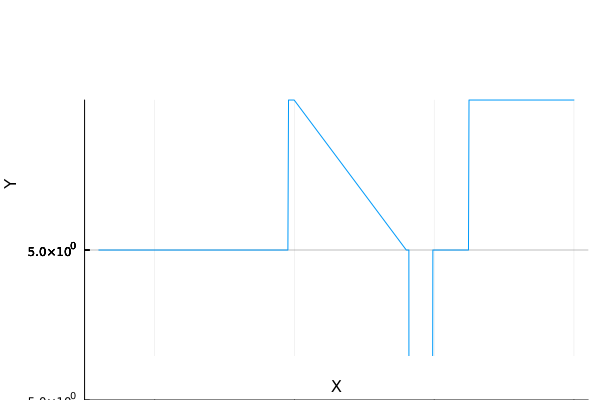

In [45]:

model = Model(Ipopt.Optimizer)

# Time points for each segment
# waypoints = [3 14 14;
#             5 5 15];

# make 3 waypoints for  a straight line
waypoints = [3 14 20;
             5 5 5];

# waypoints = [6,3,6,3,6,6;
#              2,5,9,13,16,18]
m = size(waypoints)[2]
tf = 10

t_bounds = LinRange(0, tf, m)



# Define decision variables
@variable(model, a[1:5, 1:m-1])
@variable(model, b[1:5, 1:m-1])

# Objective function
#
@NLobjective(model, Min, 
        sum(  192*a[4,i]*(t_bounds[i+1] - t_bounds[i])^3 + 144*a[4,i]*a[3,i]*(t_bounds[i+1] - t_bounds[i])^2 + 36*a[3,i]*(t_bounds[i+1] - t_bounds[i]) for i = 1:m-1) +
        sum(  192*b[4,i]*(t_bounds[i+1] - t_bounds[i])^3 + 144*b[4,i]*b[3,i]*(t_bounds[i+1] - t_bounds[i])^2 + 36*b[3,i]*(t_bounds[i+1] - t_bounds[i]) for i = 1:m-1))


# Function to give the t vector of a 4th order polynomial
function poly4(t)
    return [1; t; t^2; t^3; t^4]'
end

# Function to give the derivative of the t vector of a 4th order polynomial
function poly4d(t)
    return [0; 1; 2*t; 3*t^2; 4*t^3]'
end

# Function to give the second derivative of the t vector of a 4th order polynomial
function poly4dd(t)
    return [0; 0; 2; 6*t; 12*t^2]'
end

# Function to give the third derivative of the t vector of a 4th order polynomial
function poly4ddd(t)
    return [0; 0; 0; 6; 24*t]'
end

# Function to give the fourth derivative of the t vector of a 4th order polynomial
function poly4dddd(t)
    return [0; 0; 0; 0; 24]'
end



# Constraints

# enforces zero velocity, acceleration, jerk, and snap at the initial time t0
@constraint(model, poly4d(t_bounds[1])*a[:,1] == 0)
@constraint(model, poly4dd(t_bounds[1])*a[:,1] == 0)
#@constraint(model, poly4ddd(t_bounds[1])*a[:,1] == 0)
#@constraint(model, poly4dddd(t_bounds[1])*a[:,1] == 0)

# for y
@constraint(model, poly4d(t_bounds[1])*b[:,1] == 0)
@constraint(model, poly4dd(t_bounds[1])*b[:,1] == 0)
#@constraint(model, poly4ddd(t_bounds[1])*b[:,1] == 0)
#@constraint(model, poly4dddd(t_bounds[1])*b[:,1] == 0)

# enforces zero velocity, acceleration, jerk, and snap at the final time tm
@constraint(model, poly4d(t_bounds[m-1])*a[:,m-1] == 0)
@constraint(model, poly4dd(t_bounds[m-1])*a[:,m-1] == 0)
#@constraint(model, poly4ddd(t_bounds[m-1])*a[:,m-1] == 0)
#@constraint(model, poly4dddd(t_bounds[m-1])*a[:,m-1] == 0)

# for y
@constraint(model, poly4d(t_bounds[m-1])*b[:,m-1] == 0)
@constraint(model, poly4dd(t_bounds[m-1])*b[:,m-1] == 0)
#@constraint(model, poly4ddd(t_bounds[m-1])*b[:,m-1] == 0)
#@constraint(model, poly4dddd(t_bounds[m-1])*b[:,m-1] == 0)


if m == 3
    # Match waypoints
    @constraint(model, poly4(t_bounds[1])*a[:,1] == waypoints[1,1])
    @constraint(model, poly4(t_bounds[2])*a[:,2] == waypoints[1,2])
    @constraint(model, poly4(t_bounds[3])*a[:,2] == waypoints[1,3]) 

    # match y
    @constraint(model, poly4(t_bounds[1])*b[:,1] == waypoints[2,1])
    @constraint(model, poly4(t_bounds[2])*b[:,2] == waypoints[2,2])
    @constraint(model, poly4(t_bounds[3])*b[:,2] .== waypoints[2,3])

    # enforces continuity of the position, velocity, acceleration, jerk, and snap of xT at t = t1, . . . , tm−1
    # For three points there is only one middle point
    @constraint(model, poly4(t_bounds[2])*a[:,1] .== poly4(t_bounds[1])*a[:,2])
    @constraint(model, poly4d(t_bounds[2])*a[:,1] .== poly4d(t_bounds[1])*a[:,2])
    @constraint(model, poly4dd(t_bounds[2])*a[:,1] .== poly4dd(t_bounds[1])*a[:,2])
    #@constraint(model, poly4ddd(t_bounds[2])*a[:,1] .== poly4ddd(t_bounds[1])*a[:,2])
    #@constraint(model, poly4dddd(t_bounds[2])*a[:,1] .== poly4dddd(t_bounds[1])*a[:,2])

    @constraint(model, poly4(t_bounds[2])*b[:,1] .== poly4(t_bounds[1])*b[:,2])
    @constraint(model, poly4d(t_bounds[2])*b[:,1] .== poly4d(t_bounds[1])*b[:,2])
    @constraint(model, poly4dd(t_bounds[2])*b[:,1] .== poly4dd(t_bounds[1])*b[:,2])
    #@constraint(model, poly4ddd(t_bounds[2])*b[:,1] .== poly4ddd(t_bounds[1])*b[:,2])
    #@constraint(model, poly4dddd(t_bounds[2])*b[:,1] .== poly4dddd(t_bounds[1])*b[:,2])
end


# Solve the optimization problem
optimize!(model)

# Retrieve optimized trajectory
a_opt = value.(a)
b_opt = value.(b)

n = 1000
t = LinRange(0, tf, n)
x_arr = zeros(n)
y_arr = zeros(n)
for i = 1:n
    if m == 3
        if t[i] <= t_bounds[2]
            x_arr[i] = poly4(t[i])*a_opt[:,1]
            y_arr[i] = poly4(t[i])*b_opt[:,1]
        else
            x_arr[i] = poly4(t[i])*a_opt[:,2]
            y_arr[i] = poly4(t[i])*b_opt[:,2]
        end
    end
end

plot(x_arr, y_arr, xlabel="X", ylabel="Y", legend=false)





This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       35
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        4

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       10
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.00e+01 3.60e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

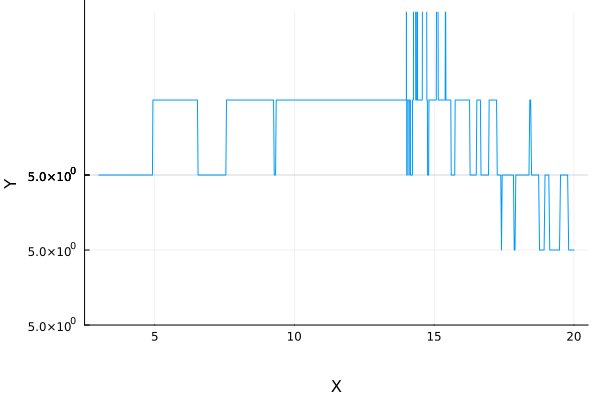

In [46]:
function get_polys(idx,tf,waypoints)
    model = Model(Ipopt.Optimizer)
    m = size(waypoints)[2]
    t_bounds = LinRange(0, tf, m)



    # Define decision variables
    @variable(model, a[1:5, 1:m-1])

    # Objective function
    #
    # @objective(model, Min, 
    #         sum(  192*a[4,i]*(t_bounds[i+1] - t_bounds[i])^3 + 144*a[4,i]*a[3,i]*(t_bounds[i+1] - t_bounds[i])^2 + 36*a[3,i] for i = 1:m-1))

    @objective(model, Min, 
            sum(  576*a[4,i]^2*(t_bounds[i+1] - t_bounds[i])^2 + 288*a[4,i]*a[3,i]*(t_bounds[i+1] - t_bounds[i]) + 36*a[3,i]  for i = 1:m-1))


    # Constraints

    # enforces zero velocity, acceleration, jerk, and snap at the initial time t0
    @constraint(model, poly4d(t_bounds[1])*a[:,1] == 0)
    @constraint(model, poly4dd(t_bounds[1])*a[:,1] == 0)
    #@constraint(model, poly4ddd(t_bounds[1])*a[:,1] == 0)
    #@constraint(model, poly4dddd(t_bounds[1])*a[:,1] == 0)

    # enforces zero velocity, acceleration, jerk, and snap at the final time tm
    @constraint(model, poly4d(t_bounds[m-1])*a[:,m-1] == 0)
    @constraint(model, poly4dd(t_bounds[m-1])*a[:,m-1] == 0)
    #@constraint(model, poly4ddd(t_bounds[m-1])*a[:,m-1] == 0)
    #@constraint(model, poly4dddd(t_bounds[m-1])*a[:,m-1] == 0)


    if m == 3
        # Match waypoints
        @constraint(model, poly4(t_bounds[1])*a[:,1] == waypoints[idx,1])
        @constraint(model, poly4(t_bounds[2])*a[:,2] == waypoints[idx,2])
        @constraint(model, poly4(t_bounds[3])*a[:,2] == waypoints[idx,3]) 

        # enforces continuity of the position, velocity, acceleration, jerk, and snap of xT at t = t1, . . . , tm−1
        # For three points there is only one middle point
        @constraint(model, poly4(t_bounds[2])*a[:,1] .== poly4(t_bounds[1])*a[:,2])
        @constraint(model, poly4d(t_bounds[2])*a[:,1] .== poly4d(t_bounds[1])*a[:,2])
        @constraint(model, poly4dd(t_bounds[2])*a[:,1] .== poly4dd(t_bounds[1])*a[:,2])
        #@constraint(model, poly4ddd(t_bounds[2])*a[:,1] .== poly4ddd(t_bounds[1])*a[:,2])
        #@constraint(model, poly4dddd(t_bounds[2])*a[:,1] .== poly4dddd(t_bounds[1])*a[:,2])

    end


    # Solve the optimization problem
    optimize!(model)

    # Retrieve optimized trajectory
    a_opt = value.(a)

end

# Time points for each segment
waypoints = [3 14 14;
            5 5 15];

# straight line
waypoints = [3 14 20;
             5 5 5];
m = size(waypoints)[2]
tf = 10

ax = get_polys(1,tf,waypoints)
ay = get_polys(2,tf,waypoints)

# plot
n = 1000
t = LinRange(0, tf, n)
x_arr = zeros(n)
y_arr = zeros(n)

for i = 1:n
    if m == 3
        if t[i] <= t_bounds[2]
            x_arr[i] = poly4(t[i])*ax[:,1]
            y_arr[i] = poly4(t[i])*ay[:,1]
        else
            x_arr[i] = poly4(t[i])*ax[:,2]
            y_arr[i] = poly4(t[i])*ay[:,2]
        end
    end
end

plot(x_arr, y_arr, xlabel="X", ylabel="Y", legend=false)





In [37]:
2^(2*3)

64